# Introduction
#### Author: Kaj Meijer
This notebook contains the code for **The relation of responsivity and neg-raising** discussed in the method.

In [1]:
# import block
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from nltk.corpus import brown, reuters, gutenberg
from collections import Counter

In [2]:
# load the negraising dataset
df_negraising = pd.read_csv('data/mega-negraising-v1.tsv', sep="\t")

# load the acceptability dataset for evaluation
df_acceptability = pd.read_csv('data/mega-acceptability-v1-normalized.tsv', sep="\t")

In [3]:
'''
Process pseudo frame by adding the complements to them
@param  list                The frames without complements
@return np.array, np.array  Two np arrays consisting of frames with complements
'''
def process_frames(pseudo_frames):
    
    # initial empty lists
    that_frames = []
    whether_frames = []
    
    # iterate over the pseudo frames
    for frame in pseudo_frames:
        
        # different versions of the datasets use different frame formats
        # add the complement to the frame and add it to the result list
        if "Ved" in frame:
            that_frames.append(frame.replace("Ved", "Ved that"))
            whether_frames.append(frame.replace("Ved", "Ved whether"))
        else:
            that_frames.append(frame.replace("V", "V that"))
            whether_frames.append(frame.replace("V", "V whether"))
        
    # return the processed frames
    return np.array(that_frames), np.array(whether_frames)

In [4]:
# the pseudo frames
pseudo_frames = ['NP Ved S', 'NP V S']

# process the frames
declarative_frames, interrogative_frames = process_frames(pseudo_frames)

In [5]:
def get_verbs(dataframe, frames, threshold = 0.0):
    
    # the result array for all verbs that meet the threshold for the frames
    verbs = []
    
    # iterate over the verbs
    for verb in dataframe.verb.unique():
        
        # get the judgements of the frames
        judgements = dataframe.loc[(dataframe.verb == verb) & (dataframe.frame.isin(frames))].responsenorm.dropna().values

        # skip empty score lists
        if len(judgements) == 0:
            continue
            
        # get the mean scores of the verb in the matching frames 
        acceptability = np.mean(judgements)
        
        # check if the score is high enough
        if acceptability >= threshold:
        
            # add the verb to the results
            verbs.append(verb)
    
    # return the verbs and acceptability scores
    return np.array(verbs)

In [6]:
# get the declarative and interrogative scores of the frames
declarative_verbs = get_verbs(df_acceptability, declarative_frames)
interrogative_verbs = get_verbs(df_acceptability, interrogative_frames)

# get the responsive verbs
responsive_verbs = np.array([verb for verb in declarative_verbs if verb in interrogative_verbs])

In [7]:
'''
Get acceptability score of the verbs
@param  pd.DataFrame  the acceptability dataframe
@param  np.array      the declarative verbs
@param  np.array      the frames to consider for the declarativity or interrogativity
@return np.array      the scores of verbs
'''
def acceptability(dataframe, verbs, frames):
    
    # the result array for all verbs that take declarative complements
    result = []
    
    # iterate over the verbs
    for verb in verbs:
        
        # get the judgements of the frames
        judgements = dataframe.loc[(dataframe.verb == verb) & (dataframe.frame.isin(frames))].responsenorm.dropna().values
        
        # there are no judgements, stop
        if len(judgements) == 0:
            continue
            
        # get the mean scores of the verb in the matching frames 
        acceptability = np.mean(judgements)
        
        # add the verb to the results
        result.append(acceptability)
    
    # add the result as a numpy array
    return np.array(result)

In [8]:
'''
Get the negraising judgements for a verb
@param  pd.DataFrame  the acceptability dataframe
@param  string        the verb
@return float         the negraising score
'''
def get_negraising_score(dataframe, verb, threshold = 0.0):
    
    # get the rows of the verb
    series = dataframe.loc[(dataframe.verb == verb) & (dataframe.acceptability >= threshold) & 
                           (dataframe.tense == 'past') & (dataframe.subject == 'third')]
    
    # get the judgements from the series
    judgements = series.negraising.dropna().values
    
    # there are no judgements, return 0 as a default
    if len(judgements) == 0:
        return 0
    
    # return the mean of the judgements
    return np.mean(judgements)
    
'''
Get interrogativity score of the verbs
@param  pd.DataFrame  the negraising dataframe
@param  np.array      the verbs to consider for the negraising
@param  np.array      the frames to consider for the negraising
@return np.array      the interrogativity scores of verbs
'''
def negraising_scores(dataframe, verbs, frames):
    
    # the result array for all verbs that take declarative complements
    result = []
    
    # iterate over the verbs
    for verb in verbs:

        # add the verb to the results
        result.append(get_negraising_score(dataframe, verb))
        
    # add the result as a numpy array
    return np.array(result)

In [9]:
'''
Combine all acceptability and negraising values in a single dict
@param  pd.DataFrame  the acceptability dataframe
@param  pd.DataFrame  the negraising dataframe
@param  np.array      the declarative verbs
@param  np.array      the frames to consider for the interrogativity
@param  float         the minimal score of a verb to be considered declarative
@return dict          the verbs that take declarative complements and the average judgement scores 
'''
def combine_measures(df_acceptability, df_negraising, verbs, frames_declarative, frames_interrogative):
    
    # the result array for all verbs that take declarative complements
    result = { "verb": verbs }
    
    # get the scores of the acceptability and negraising
    result["declarativity"] = acceptability(df_acceptability, verbs, frames_declarative)
    result["interrogativity"] = acceptability(df_acceptability, verbs, frames_interrogative)
    result["negraising"] = negraising_scores(df_negraising, verbs, frames_declarative)
    
    # return the dict
    return result

In [10]:
# put all info in a dict
responsive_measures = combine_measures(df_acceptability, df_negraising, responsive_verbs, declarative_frames, interrogative_frames)

In [11]:
'''
Plot the interrogative vs negraising points and linear regression
@param  dict  
'''
def plot(values):
    
    # get the X and y  values for the linear regression
    X = np.array(values["negraising"]).T.reshape(-1, 1)
    y = np.array(values["interrogativity"])

    # fit the linear regression model
    reg = LinearRegression().fit(X, y)

    # get the linear regression line
    pred = reg.predict(X)

    # plot the points and regression 
    plt.plot(values["negraising"], values["interrogativity"], "b.")
    plt.plot(values["negraising"], pred)

    # set the labels
    plt.xlabel('neg-raising')
    plt.ylabel('responsivity')

In [12]:
'''
Get the responsive neg-raising predicates
@param  dict        a dict with the properties:
                        - verb:np.array
                        - negraising:np.array
                        - interrogativity:np.array
@return np.array    the counter examples
'''
def get_responsive_negraising(values, declarative_threshold = 2.120, interrogative_threshold = 1.661, negraising_threshold = 0.529):
    
    # initial list for the counter examples
    counterexamples = []

    # zip the 
    zipped = zip(values["verb"], values["declarativity"], values["interrogativity"], values["negraising"])
    
    # get the values that meet all thresholds
    result = [x for x in zipped if 
              x[1] > declarative_threshold and 
              x[2] > interrogative_threshold and 
              x[3] > negraising_threshold]
            
    # return the sorted counterexamples
    return np.array(sorted(result, key=lambda x: x[0]))

In [13]:
# get the responsive neg-raising predicates
responsive_negraising = get_responsive_negraising(responsive_measures)

In [14]:
# print the responsive neg-raising predicates
responsive_negraising

array([['conclude', '2.617543935775757', '1.7462099790573116', '0.5605'],
       ['decide', '2.791567087173462', '1.9708629846572883',
        '0.5796666666666667'],
       ['detect', '4.035161018371582', '2.1081557273864746', '0.5295'],
       ['discover', '3.4458818435668945', '2.4101345539093018', '0.535'],
       ['like', '2.24820613861084', '1.9810391664505005', '0.561'],
       ['pinpoint', '2.3524763584136963', '2.035661458969116', '0.531'],
       ['see', '2.4129984378814697', '2.4211721420288086',
        '0.5396666666666667'],
       ['surmise', '2.6682651042938232', '2.0609056949615483',
        '0.5369999999999999']], dtype='<U18')

In [15]:
# get the processed frames
declarative_frames, interrogative_frames = process_frames(pseudo_frames)

# display the rows in the dataframe that belong to the counter examples
display(df_acceptability.loc[(df_acceptability.verb.isin(responsive_negraising[:, 0])) & 
                             (df_acceptability.frame.isin(np.concatenate((declarative_frames, interrogative_frames), axis=None)))])


,verb,verbform,frame,sentence,responsenorm,responsevar
9069,conclude,concluded,NP Ved that S,Someone concluded that something happened .,2.617544,-0.985143
9079,conclude,concluded,NP Ved whether S,Someone concluded whether something happened .,1.746210,-1.526984
11769,decide,decided,NP Ved that S,Someone decided that something happened .,2.791567,-0.714324
11779,decide,decided,NP Ved whether S,Someone decided whether something happened .,1.970863,-0.793193
13469,detect,detected,NP Ved that S,Someone detected that something happened .,4.035161,-0.583605
13479,detect,detected,NP Ved whether S,Someone detected whether something happened .,2.108156,-0.964108
14419,discover,discovered,NP Ved that S,Someone discovered that something happened .,3.445882,-0.738023
14429,discover,discovered,NP Ved whether S,Someone discovered whether something happened .,2.410135,-0.565744
28119,like,liked,NP Ved that S,Someone liked that something happened .,2.248206,-1.133537
28129,like,liked,NP Ved whether S,Someone liked whether something happened .,1.981039,-1.384534


In [16]:
# display the rows in the dataframe that belong to the counter examples
display(df_negraising.loc[(df_negraising.verb.isin(responsive_negraising[:, 0])) &
                          (df_negraising.frame.isin(declarative_frames)) &
                          (df_negraising.tense == 'past') & 
                          (df_negraising.subject == 'third')])

,participant,list,presentationorder,verb,frame,tense,subject,sentence,negraising,acceptability,nativeenglish
14610,880,189,15,conclude,NP V that S,past,third,a particular person didn't conclude that a par...,0.43,0.64,True
14611,11,189,18,conclude,NP V that S,past,third,a particular person didn't conclude that a par...,1.00,1.00,True
14612,420,189,9,conclude,NP V that S,past,third,a particular person didn't conclude that a par...,0.33,0.40,True
14613,392,189,12,conclude,NP V that S,past,third,a particular person didn't conclude that a par...,0.31,0.88,True
14614,1077,189,9,conclude,NP V that S,past,third,a particular person didn't conclude that a par...,0.45,0.58,True
14615,459,189,6,conclude,NP V that S,past,third,a particular person didn't conclude that a par...,0.09,0.61,True
14616,117,189,3,conclude,NP V that S,past,third,a particular person didn't conclude that a par...,0.62,0.65,True
14617,414,189,16,conclude,NP V that S,past,third,a particular person didn't conclude that a par...,0.84,0.63,True
14618,898,189,14,conclude,NP V that S,past,third,a particular person didn't conclude that a par...,0.83,0.92,True
14619,424,189,16,conclude,NP V that S,past,third,a particular person didn't conclude that a par...,0.70,0.34,True


In [17]:
# print all responsive neg-raising predictes (without the values)
responsive_negraising[:, 0]

array(['conclude', 'decide', 'detect', 'discover', 'like', 'pinpoint',
       'see', 'surmise'], dtype='<U18')

In [18]:
# process the values of the predicates with a positive declarativity measure 
plot_dict = combine_measures(df_acceptability, df_negraising, declarative_verbs, declarative_frames, interrogative_frames)

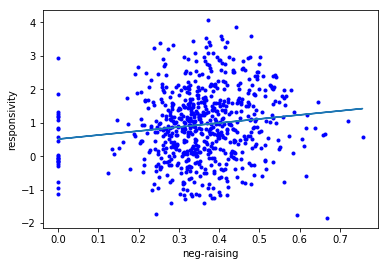

In [19]:
# plot the predicate measures with a linear regression
plot(plot_dict)

# Evaluation

In [20]:
# the corpora to evaluate
corpora = [brown, reuters, gutenberg]

In [21]:
'''
Retrieve the sentences with interrogative complements that contain responsive neg-raising predicates 
@param  list      The list with corpora
@param  np.array  The list with responsive neg-raising predicates
@return np.array  The list with 
'''
def sentences_interrogative_complements(corpora, verbs):
    
    # initial list for the results
    result = []
    
    # iterate over the corpora
    for corpus in corpora:
        
        # iterate over the sentences
        for sentence in corpus.sents():
            
            # skip the sentence if it does not have an interrogative complement
            if not 'whether' in sentence:
                continue
            
            # get the locations of the word whether in the sentence
            indices = [i for i, word in enumerate(sentence) if word == "whether"]
            
            words = [sentence[i-1] for i in indices]
            
            if any(word in verbs for word in words):
                
                result.append(sentence)
    
    return np.array(result)

In [22]:
# get all unique verbforms
verbforms = df_acceptability.loc[df_acceptability.verb.isin(responsive_negraising[:, 0])].verbform.unique()

# get the sentences that validate the counter examples
interrogative_sentences = sentences_interrogative_complements(corpora, verbforms)

In [23]:
# print the number of sentences with counterexamples
print(len(interrogative_sentences))

# print the sentences in a more readable manner
for sentence in interrogative_sentences:
    print(' '.join(sentence))
    print()

63
Said he : `` We will see whether whites and Negroes are treated the same around here '' .

`` When I was a kid '' , Maris told a sportswriter last week , `` I used to follow Williams every day in the box score , just to see whether he got a hit or not '' .

The British Government will have to decide whether to let U.S. coal in .

Religion , or the lack of it , will decide whether we use this power to build a brave new world of peace and abundance for all mankind , or whether we misuse this power to leave a world utterly destroyed .

Now the original absent sitter must decide whether the statements are meaningful to him .

Work is under way to see whether new restraining devices should be installed on all nuclear weapons .

The decision maker who acts for the community as a whole must decide whether the objectives pursued and the methods used are appropriate to public policy regarding cultural groups .

To avoid passing over quiet , unaggressive teachers as well as to decide whether 

In [24]:
# the initial list
confirmed_responsive_negraising = []

# iterate over the sentences
for sentence in interrogative_sentences:
          
    # get the indices of the word "whether"   
    indices = [i for i, word in enumerate(sentence) if word == "whether"]
    
    # collect the responsive negraising predicates 
    predicates = [sentence[i-1] for i in indices if sentence[i-1] in verbforms]

    # create one big list of all predicates
    confirmed_responsive_negraising = confirmed_responsive_negraising + predicates
    
# create a counter for the predicates and print it
Counter(confirmed_responsive_negraising)

Counter({'see': 34, 'decide': 19, 'decided': 10})

# Manual analysis

In [25]:
# get the values of the all verbs
all_values = combine_measures(df_acceptability, df_negraising, df_acceptability.verb.unique(), declarative_frames, interrogative_frames)

In [26]:
# calculate the standard deviation and mean of the declarativity
declarativity_threshold = np.std(all_values["declarativity"])
d_mean = np.mean(all_values["declarativity"])
print(declarativity_threshold, d_mean, declarativity_threshold + d_mean)

1.3509716010769317 0.7692324667773649 2.1202040678542966


In [27]:
# calculate the standard deviation and mean of the interrogativity
interrogativity_threshold = np.std(all_values["interrogativity"])
i_mean =  np.mean(all_values["interrogativity"])
print(interrogativity_threshold, i_mean, interrogativity_threshold + i_mean)

1.2155624855138607 0.44566850902077065 1.6612309945346313


## Predicates above the threshold of zero

In [28]:
# get the values of the declarative verbs
declarative_values = combine_measures(df_acceptability, df_negraising, declarative_verbs, declarative_frames, interrogative_frames)

In [29]:
# zip all values for sorting and sort them from lowest to highest declarative value
zipped = zip(declarative_values["verb"], declarative_values["declarativity"], declarative_values["interrogativity"], declarative_values["negraising"])
declarative_sorted = np.array(sorted(zipped, key=lambda x: x[1]))

# print the number of declarative predicates and show the 10 lowest values
print(len(declarative_sorted))
print(declarative_sorted[:10])

677
[['coach' '0.0010327760828658938' '-0.23661063611507416'
  '0.40024999999999994']
 ['conspire' '0.0015376537339761849' '1.4274568557739258' '0.3885']
 ['wow' '0.006122334394603968' '-1.1736241579055786' '0.312']
 ['relax' '0.006840691901743412' '-0.6527819037437439' '0.331']
 ['blame' '0.011507118120789528' '-0.3749268352985382'
  '0.4055000000000001']
 ['appraise' '0.01889432966709137' '0.7117559313774109' '0.312']
 ['irritate' '0.019155414775013924' '-1.1882097721099854' '0.333']
 ['banter' '0.04121265187859535' '0.5958866477012634' '0.471']
 ['illuminate' '0.041438691318035126' '0.507764995098114'
  '0.33999999999999997']
 ['quote' '0.04290352389216423' '-0.07284806668758392' '0.443']]


In [30]:
# get the values of the interrogative verbs
interrogative_values = combine_measures(df_acceptability, df_negraising, interrogative_verbs, declarative_frames, interrogative_frames)

In [31]:
# zip all values for sorting and sort them from lowest to highest interrogative value
zipped = zip(interrogative_values["verb"], interrogative_values["declarativity"], interrogative_values["interrogativity"], interrogative_values["negraising"])
interrogative_sorted = np.array(sorted(zipped, key=lambda x: x[2]))

# print the number of interrogative predicates and show the 10 lowest values
print(len(interrogative_sorted))
print(interrogative_sorted[:10])

618
[['chirp' '0.7779699563980103' '0.0024867176543921232'
  '0.28900000000000003']
 ['weep' '1.7736704349517822' '0.00701726321130991' '0.30799999999999994']
 ['bark' '1.253892183303833' '0.0076591745018959045' '0.276']
 ['respect' '1.0238806009292605' '0.01349879615008831' '0.0']
 ['cover' '-0.5349055528640747' '0.013912688009440902' '0.0']
 ['sketch' '1.2779922485351562' '0.014985631220042706' '0.43']
 ['televise' '1.4356533288955688' '0.016248680651187897' '0.345']
 ['demand' '1.3918601274490356' '0.017235949635505676'
  '0.34324999999999994']
 ['croon' '0.3987816572189331' '0.031107665970921523' '0.0']
 ['enlighten' '-0.4678671061992645' '0.045646071434020996' '0.31']]


## Predicates above the threshold of standard deviation + mean 

In [32]:
# zip all values
zipped = zip(all_values["verb"], all_values["declarativity"], all_values["interrogativity"], all_values["negraising"])

# remove the predicates that don't meet the declarativity threshold and sort from lowest to highest
thresholded_sorted_declarativity = np.array(sorted([x for x in zipped if x[1] > declarativity_threshold + d_mean ], key=lambda x: x[1]))

# print the number of interrogative predicates and show the 10 lowest values
print(len(thresholded_sorted_declarativity))
print(thresholded_sorted_declarativity[:10])

178
[['freak_out' '2.1222262382507324' '1.1671963930130005' '0.28875']
 ['certify' '2.12554931640625' '1.6158958673477173' '0.3546']
 ['express' '2.1326322555541988' '2.373464107513428' '0.3725']
 ['perceive' '2.1339688301086426' '0.8465897440910339'
  '0.6166666666666668']
 ['celebrate' '2.1415786743164062' '0.7009185552597046'
  '0.21999999999999997']
 ['chronicle' '2.1444652080535893' '2.129568576812744'
  '0.32799999999999996']
 ['growl' '2.148998737335205' '0.5139069557189941' '0.27599999999999997']
 ['respond' '2.1536552906036377' '1.5738878250122068'
  '0.32333333333333325']
 ['rant' '2.1550471782684326' '1.0079996585845947' '0.3555']
 ['testify' '2.1651043891906743' '3.5930655002593994'
  '0.40425000000000005']]


In [33]:
# zip all values 
zipped = zip(all_values["verb"], all_values["declarativity"], all_values["interrogativity"], all_values["negraising"])

# remove the predicates that don't meet the interrogativity threshold and sort from lowest to highest
thresholded_sorted_interrogativity = np.array(sorted([x for x in zipped if x[2] > interrogativity_threshold + i_mean ], key=lambda x: x[2]))

# print the number of interrogative predicates and show the 10 lowest values
print(len(thresholded_sorted_interrogativity))
print(thresholded_sorted_interrogativity[:10])

164
[['warn' '2.2581787109375' '1.6686369180679317' '0.3665']
 ['disregard' '2.0789744853973398' '1.6725445985794067' '0.2225']
 ['suggest' '1.351576566696167' '1.6758385896682744' '0.4465']
 ['add' '2.903774738311768' '1.6773024797439575' '0.3143333333333333']
 ['radio' '2.8215653896331787' '1.6775916814804073' '0.21566666666666665']
 ['ascertain' '2.6959848403930664' '1.6911135911941528'
  '0.4013333333333334']
 ['reminisce' '1.7682417631149292' '1.6965881586074834' '0.256']
 ['tell' '0.7405563592910767' '1.7048985958099359' '0.42325']
 ['marvel' '2.1727449893951416' '1.7104935646057131'
  '0.33175000000000004']
 ['formulate' '1.1148486137390137' '1.7118467092514038'
  '0.45699999999999996']]


## The minimum and maximum values for declarativity and interrogativity

In [34]:
# print the bounderies of the declarativity range
print( np.min(all_values["declarativity"]), np.max(all_values["declarativity"]))

-2.9801058769226074 4.820295810699463


In [35]:
# print the bounderies of the interrogativity range
print( np.min(all_values["interrogativity"]), np.max(all_values["interrogativity"]))

-3.2886784076690674 4.063809871673584
